In [17]:
import ipynbname
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [18]:
%load_ext autoreload
%autoreload 2
from libraries.embeddings_utils import *
from libraries.classifier_utils import *
from libraries.file_manager_utils import *
from libraries.EmbeddingNet_utils import *
from scipy.stats import randint
from scipy.stats import uniform

project_dir = f"{os.getcwd().split('SIDS_revelation_project')[0]}SIDS_revelation_project/"
image_dataset_path = f"{project_dir}datasets/onback_onstomach_v3"
model_path_fd = f"{project_dir}/models/4.fd_weights/best.pt"
model_path_pe = f"{project_dir}/models/2.pe_weights/best.pt"

emb_builder = EmbeddingBuilder(model_path_fd, image_dataset_path, "load",weights_path_pe=model_path_pe)
embeddings = emb_builder.create_embedding(flags=True,positions=True, positions_normalized=True, geometric_info=True,k_positions_normalized=True ,k_geometric_info=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Extracting dataset info from .coco.json file:---------------------------------------------
Dataset contains 4158 valid samples, and labels are {'baby_on_back': 1, 'baby_on_stomach': 2}
------------------------------------------------------------------------------------------

Loading features from .csv----------------------------------------------------------------
Features loaded succesfully, in particular there are 4158 files in the dataset
------------------------------------------------------------------------------------------

Embedding builder initialized successfully------------------------------------------------
Face detection model: 4 (YOLOv8)
Dataset: /Users/lorenzodimaio/Download/SIDS_revelation_project/datasets/onback_onstomach_v3
Dataset dimension: 4158
Dataset labels: {'baby_safe': 0, 'baby_unsafe': 1}
---------------------------------------------------------------------------------

In [19]:
dataset = EmbeddingDataset(embeddings.to_numpy(),emb_builder.y,device=device)
model = dataset.train_embeddings(embed_dim=32, epochs=50, batch_size=128, lr=1e-3,verbose=False,weight_decay=1e-7,dropout_rate=0.05)

------------------------------------------------------------------------------------------
--------------------------------------FIRST ANALYSIS--------------------------------------
------------------------------------------------------------------------------------------


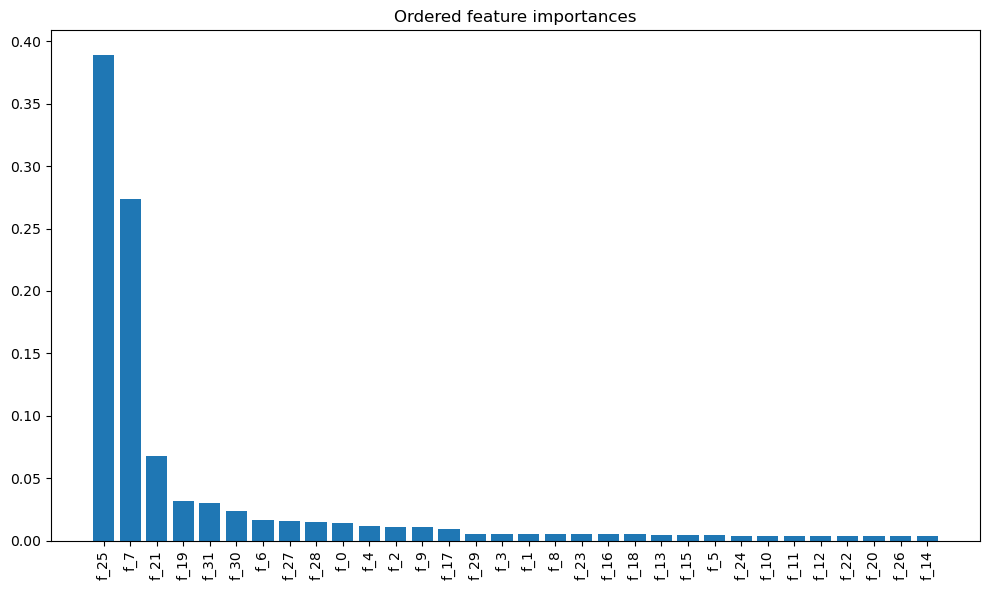

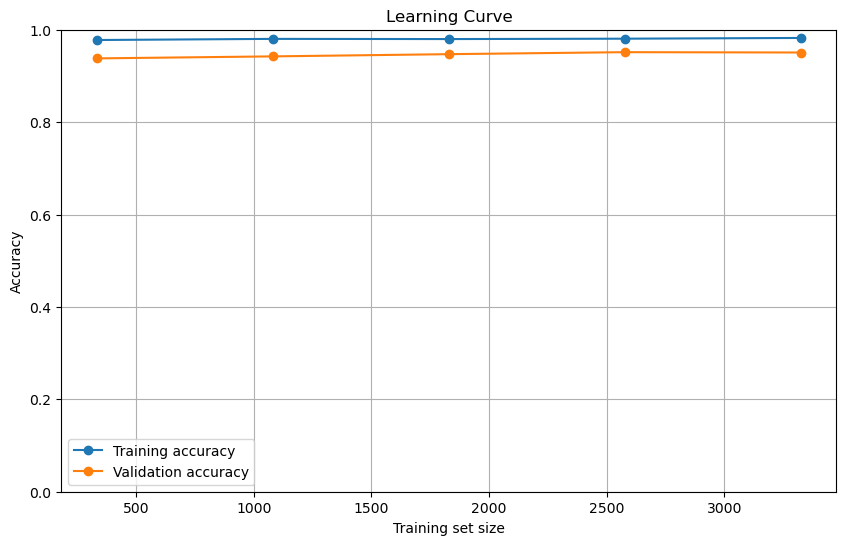


Dataset labels:----------------------------------------
{'baby_safe': 0, 'baby_unsafe': 1}

Report-------------------------------------------------
              precision    recall  f1-score   support

   baby_safe       0.95      0.95      0.95       423
 baby_unsafe       0.94      0.95      0.95       409

    accuracy                           0.95       832
   macro avg       0.95      0.95      0.95       832
weighted avg       0.95      0.95      0.95       832

Confusion matrix---------------------------------------


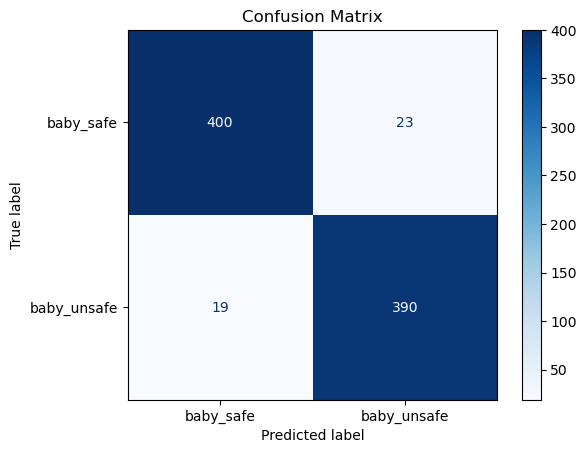

------------------------------------------------------------------------------------------
---------------------------------TOP 10 FEATURES ANALYSIS---------------------------------
------------------------------------------------------------------------------------------


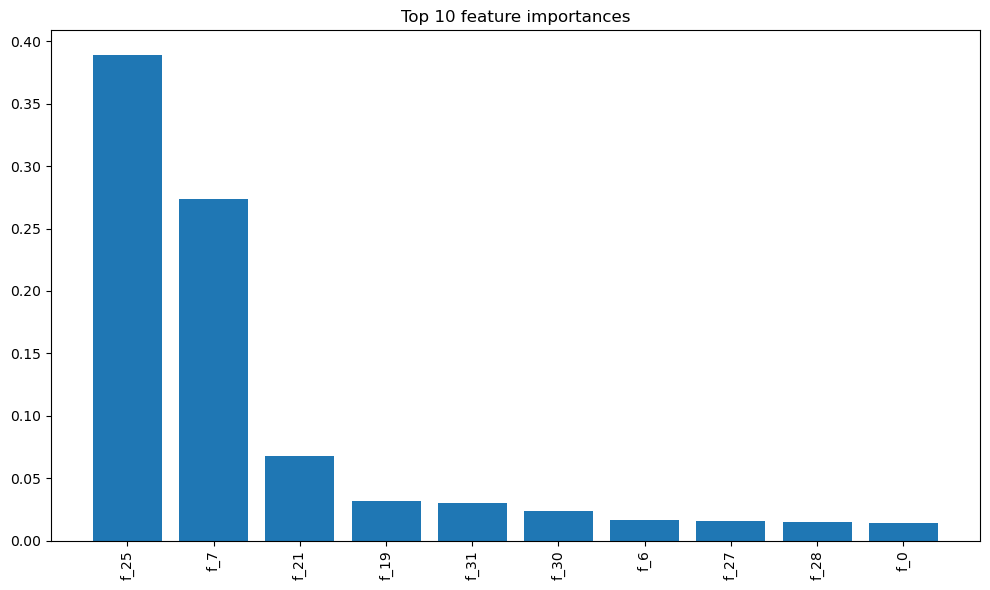

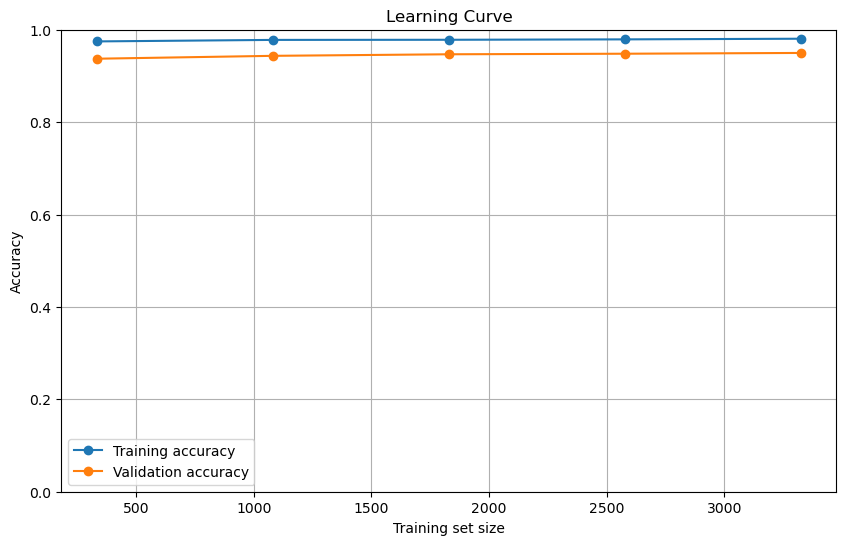


Dataset labels:----------------------------------------
{'baby_safe': 0, 'baby_unsafe': 1}

Report-------------------------------------------------
              precision    recall  f1-score   support

   baby_safe       0.95      0.94      0.95       423
 baby_unsafe       0.94      0.95      0.95       409

    accuracy                           0.95       832
   macro avg       0.95      0.95      0.95       832
weighted avg       0.95      0.95      0.95       832

Confusion matrix---------------------------------------


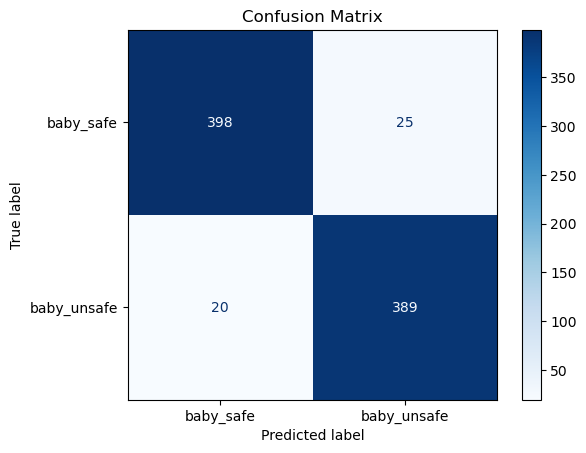

------------------------------------------------------------------------------------------
---------------------------------TOP 25 FEATURES ANALYSIS---------------------------------
------------------------------------------------------------------------------------------


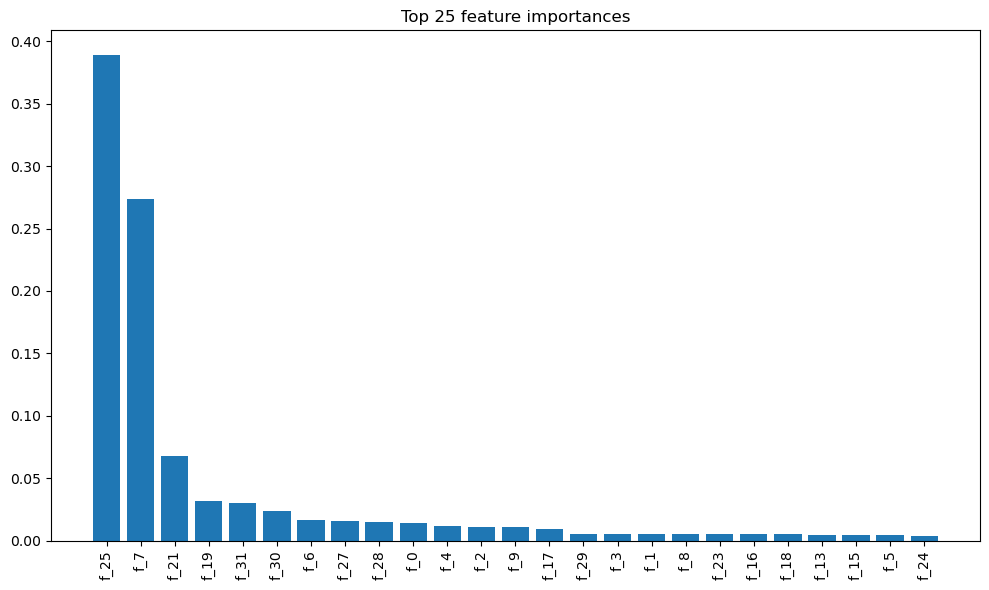

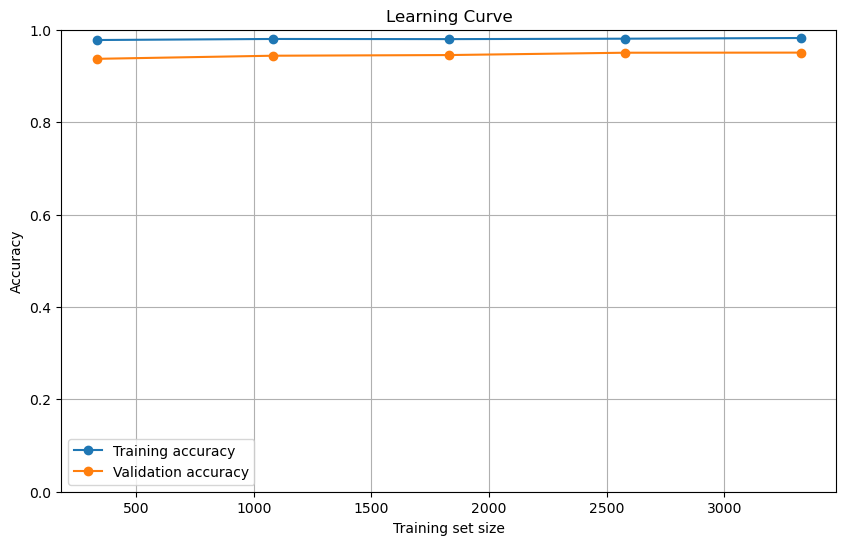


Dataset labels:----------------------------------------
{'baby_safe': 0, 'baby_unsafe': 1}

Report-------------------------------------------------
              precision    recall  f1-score   support

   baby_safe       0.96      0.94      0.95       423
 baby_unsafe       0.94      0.96      0.95       409

    accuracy                           0.95       832
   macro avg       0.95      0.95      0.95       832
weighted avg       0.95      0.95      0.95       832

Confusion matrix---------------------------------------


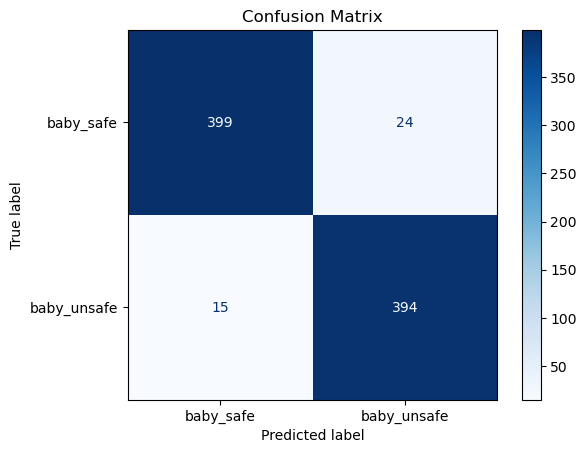

In [20]:
embeddings_new = dataset.extract_embeddings(model)
embeddings_new= pd.DataFrame(embeddings_new.to_numpy(), columns=[f"f_{i}" for i in range(embeddings_new.shape[1])])
clf = Classifier(embeddings_new, dataset.y, emb_builder.classes_bs,figsize = (10, 6))
xgbc_1, results_xgbc_1 = clf.XGBC(verbose=True)

In [21]:
clf.evaluation_pipeline_with_cv(xgbc_1,verbose=True)

------------------------------------------------------------------------------------------
-----------------------------K-FOLD CROSS-VALIDATION ANALYSIS-----------------------------
------------------------------------------------------------------------------------------
Accuracy for each fold: [0.9519230769230769, 0.9555288461538461, 0.9567307692307693, 0.9446450060168472, 0.9530685920577617]
Average cross-validation accuracy: 0.9524


np.float64(0.9523792580764603)

# 1) Ottimizziamo i parametri della rete

In [22]:
import itertools

param_grid = {
    "embed_dim": [32, 64],
    "batch_size": [64, 128],
    "lr": [1e-3, 1e-4],
    "epochs": [30,50, 100],
    "weight_decay": [1e-5, 1e-6, 1e-7],
    "dropout_rate": [0.0, 0.1, 0.2, 0.3]
}

best_acc = 0
best_params = None

for embed_dim, batch_size, lr, epochs, weight_decay, dropout_rate in itertools.product(
        param_grid["embed_dim"],
        param_grid["batch_size"],
        param_grid["lr"],
        param_grid["epochs"],
        param_grid["weight_decay"],
        param_grid["dropout_rate"]):

    # La tua istanziazione del modello e il training
    model = EmbeddingNet(input_dim=dataset.X.shape[1], embed_dim=embed_dim, dropout_rate=dropout_rate).to(device)

    trained_model, val_acc = dataset.train_and_evaluate(
        model=model,
        batch_size=batch_size,
        lr=lr,
        epochs=epochs,
        weight_decay=weight_decay,
        verbose=False
    )

    if val_acc > best_acc:
        best_acc = val_acc
        # Correzione: salva tutti gli iperparametri
        best_params = {
            "embed_dim": embed_dim,
            "batch_size": batch_size,
            "lr": lr,
            "epochs": epochs,
            "weight_decay": weight_decay,
            "dropout_rate": dropout_rate
        }

print("Best validation accuracy:", best_acc)
print("Best hyperparameters:", best_params)

Best validation accuracy: 0.9001203369434416
Best hyperparameters: {'embed_dim': 64, 'batch_size': 64, 'lr': 0.001, 'epochs': 100, 'weight_decay': 1e-07, 'dropout_rate': 0.3}


------------------------------------------------------------------------------------------
--------------------------------------FIRST ANALYSIS--------------------------------------
------------------------------------------------------------------------------------------


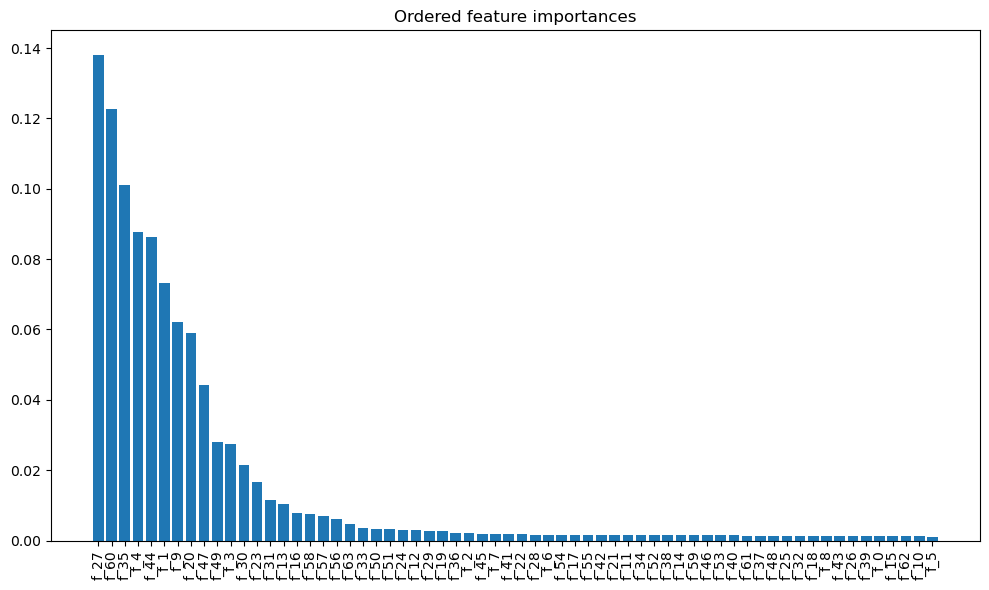

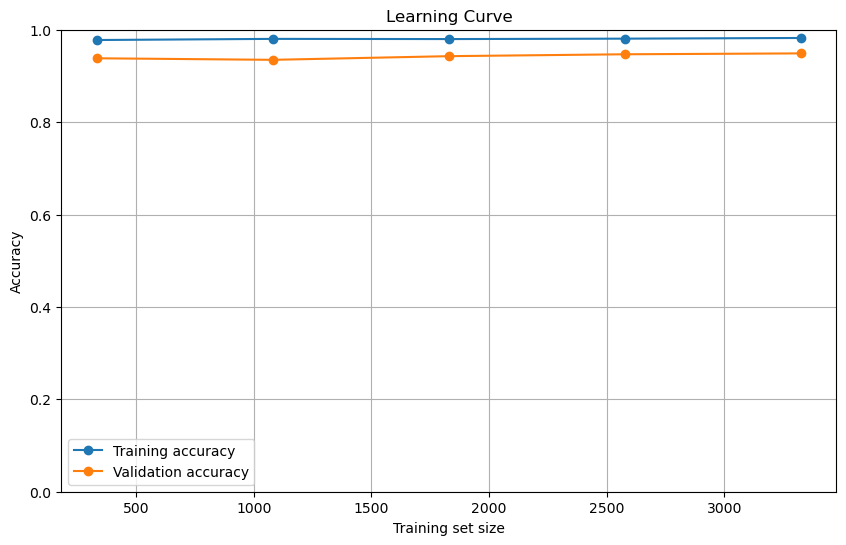


Dataset labels:----------------------------------------
{'baby_safe': 0, 'baby_unsafe': 1}

Report-------------------------------------------------
              precision    recall  f1-score   support

   baby_safe       0.95      0.94      0.95       423
 baby_unsafe       0.94      0.95      0.95       409

    accuracy                           0.95       832
   macro avg       0.95      0.95      0.95       832
weighted avg       0.95      0.95      0.95       832

Confusion matrix---------------------------------------


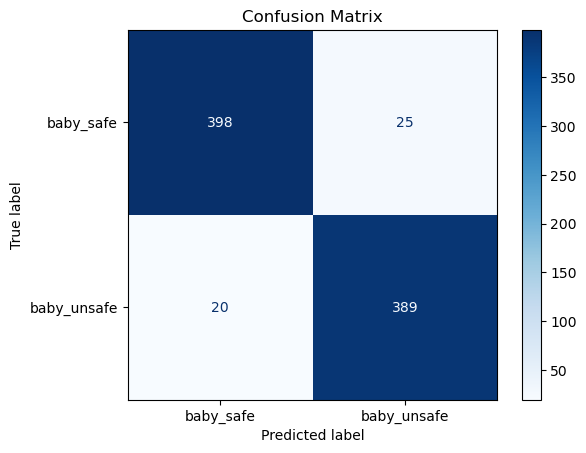

------------------------------------------------------------------------------------------
---------------------------------TOP 10 FEATURES ANALYSIS---------------------------------
------------------------------------------------------------------------------------------


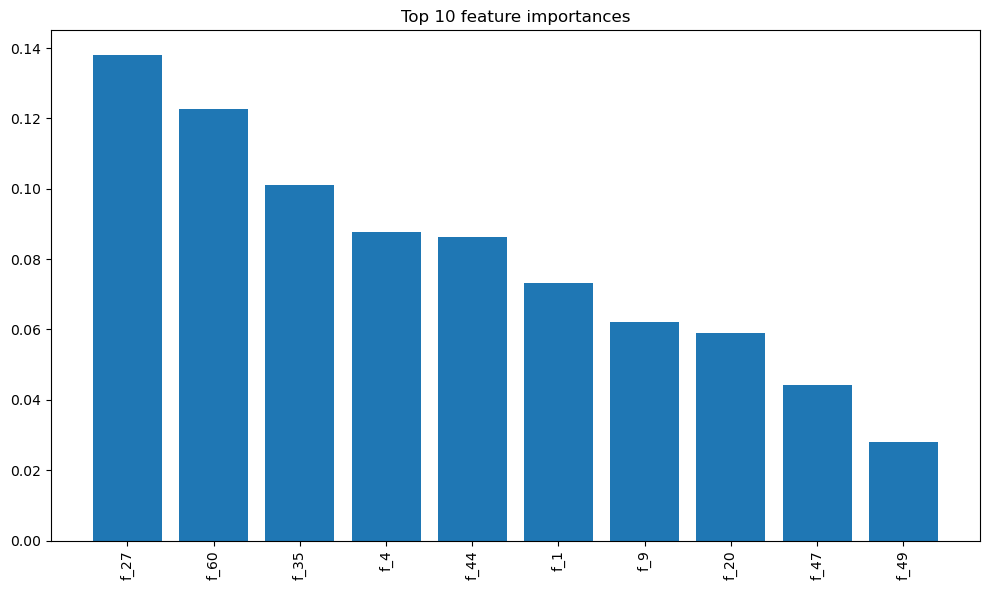

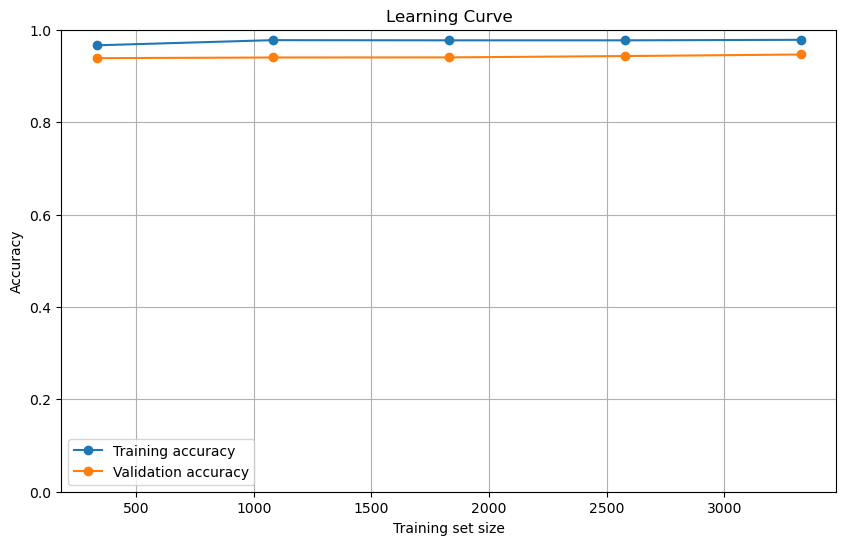


Dataset labels:----------------------------------------
{'baby_safe': 0, 'baby_unsafe': 1}

Report-------------------------------------------------
              precision    recall  f1-score   support

   baby_safe       0.96      0.93      0.94       423
 baby_unsafe       0.93      0.96      0.94       409

    accuracy                           0.94       832
   macro avg       0.94      0.94      0.94       832
weighted avg       0.94      0.94      0.94       832

Confusion matrix---------------------------------------


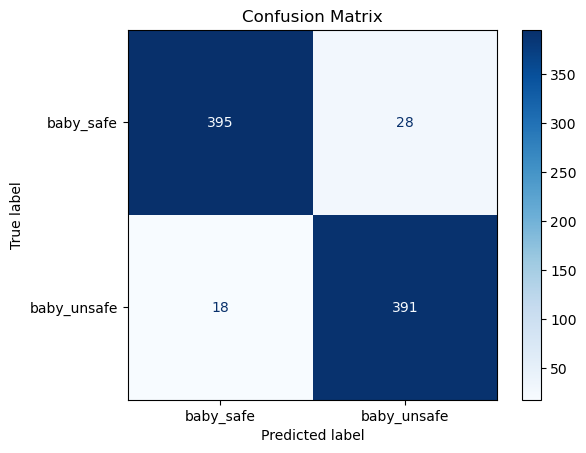

------------------------------------------------------------------------------------------
---------------------------------TOP 25 FEATURES ANALYSIS---------------------------------
------------------------------------------------------------------------------------------


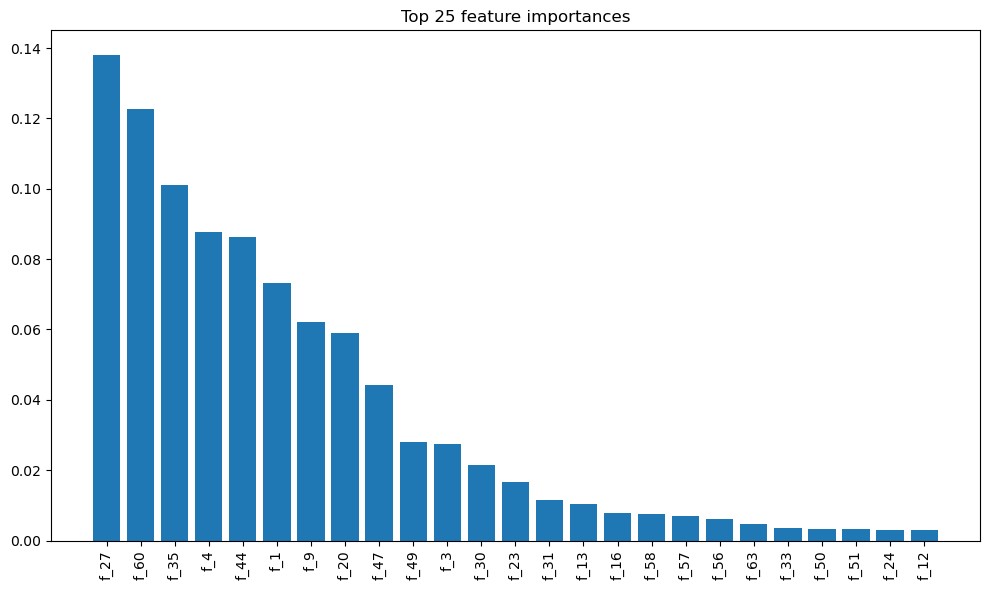

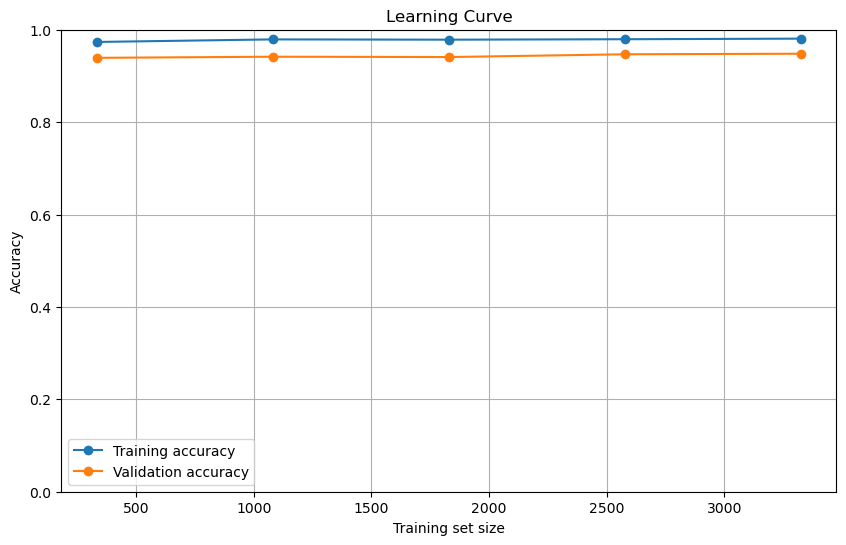


Dataset labels:----------------------------------------
{'baby_safe': 0, 'baby_unsafe': 1}

Report-------------------------------------------------
              precision    recall  f1-score   support

   baby_safe       0.96      0.94      0.95       423
 baby_unsafe       0.94      0.96      0.95       409

    accuracy                           0.95       832
   macro avg       0.95      0.95      0.95       832
weighted avg       0.95      0.95      0.95       832

Confusion matrix---------------------------------------


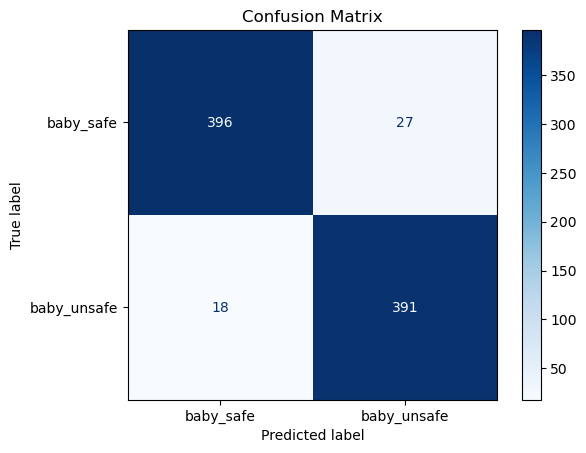

In [23]:
model = dataset.train_embeddings(**best_params,verbose=False)
embeddings_new = dataset.extract_embeddings(model)
embeddings_new= pd.DataFrame(embeddings_new.to_numpy(), columns=[f"f_{i}" for i in range(embeddings_new.shape[1])])

clf = Classifier(embeddings_new, dataset.y, emb_builder.classes_bs,figsize = (10, 6))
xgbc_1,results_xgbc_1 = clf.XGBC(verbose=True)

In [24]:
clf.evaluation_pipeline_with_cv(xgbc_1,verbose=True)

------------------------------------------------------------------------------------------
-----------------------------K-FOLD CROSS-VALIDATION ANALYSIS-----------------------------
------------------------------------------------------------------------------------------
Accuracy for each fold: [0.953125, 0.9567307692307693, 0.9543269230769231, 0.9434416365824309, 0.9446450060168472]
Average cross-validation accuracy: 0.9505


np.float64(0.9504538669813941)

# 2) Ottimizziamo i parametri del modello


Start random search...

Random Search Results:
Best parameters found:  {'colsample_bytree': np.float64(0.7970472375971478), 'gamma': np.float64(0.1643758051437541), 'learning_rate': np.float64(0.20002025629501774), 'max_depth': 5, 'n_estimators': 470, 'subsample': np.float64(0.8149053666856281)}
Best mean cross-validation accuracy:  0.9506929485876855

Evaluation of the best model on the test set:
------------------------------------------------------------------------------------------
--------------------------------------FIRST ANALYSIS--------------------------------------
------------------------------------------------------------------------------------------


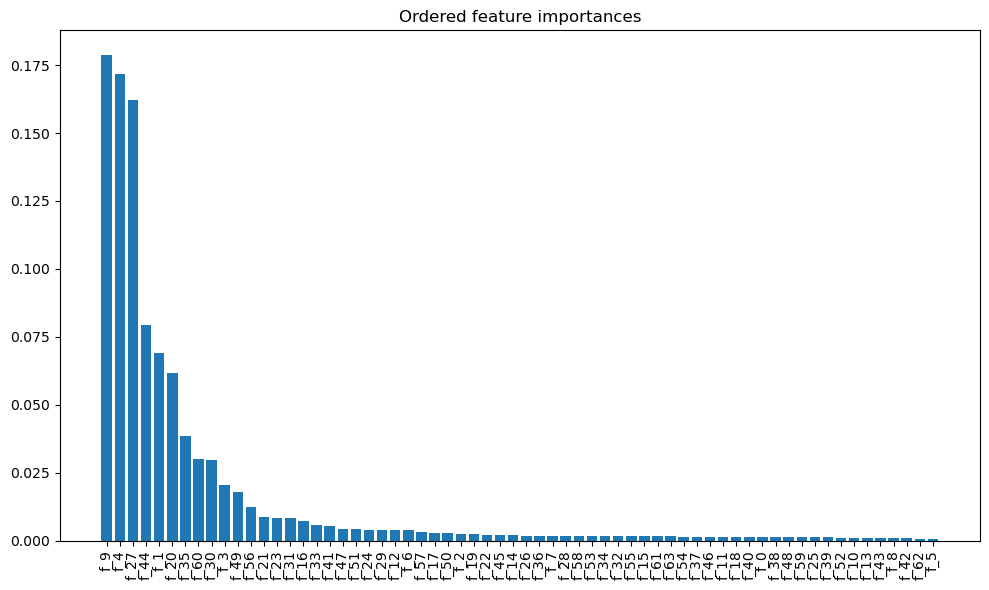

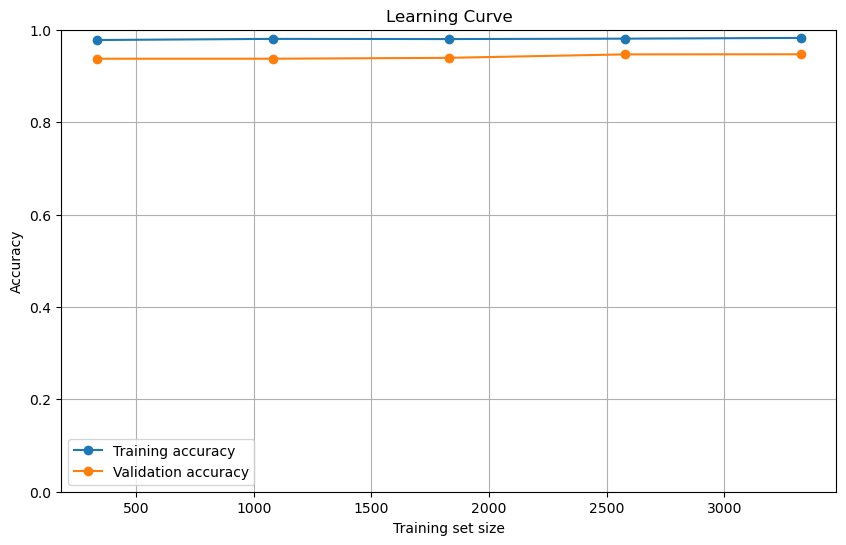


Dataset labels:----------------------------------------
{'baby_safe': 0, 'baby_unsafe': 1}

Report-------------------------------------------------
              precision    recall  f1-score   support

   baby_safe       0.95      0.94      0.94       423
 baby_unsafe       0.94      0.95      0.94       409

    accuracy                           0.94       832
   macro avg       0.94      0.94      0.94       832
weighted avg       0.94      0.94      0.94       832

Confusion matrix---------------------------------------


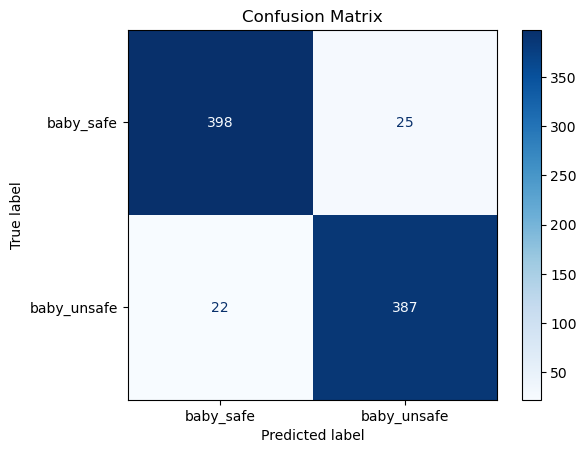

------------------------------------------------------------------------------------------
---------------------------------TOP 10 FEATURES ANALYSIS---------------------------------
------------------------------------------------------------------------------------------


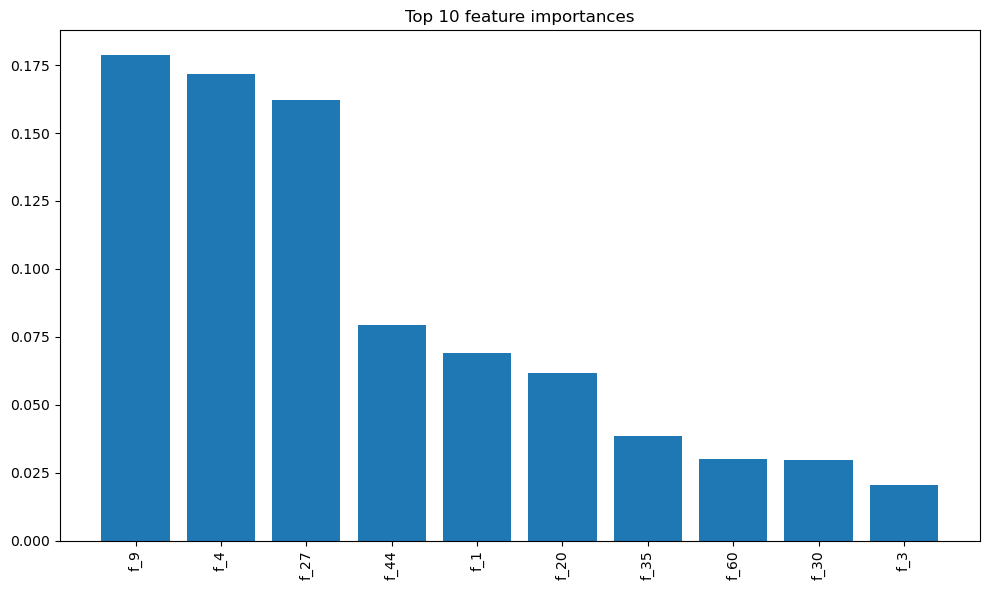

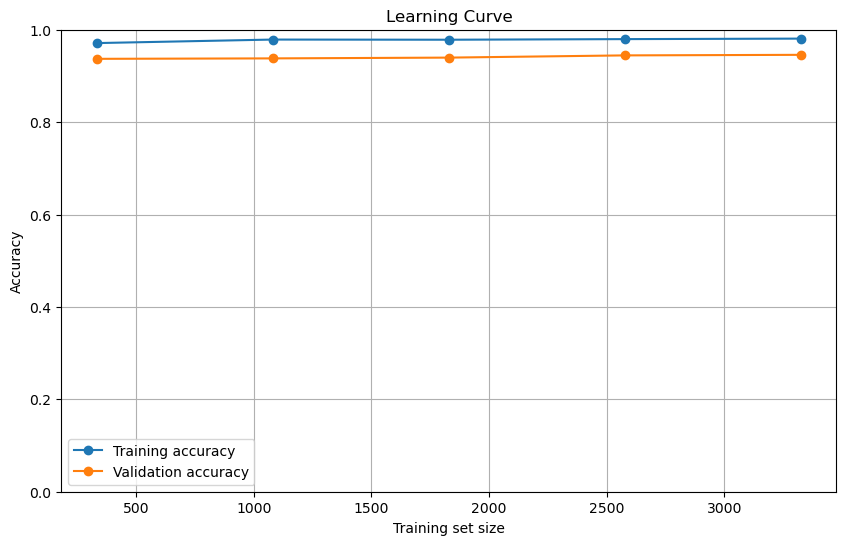


Dataset labels:----------------------------------------
{'baby_safe': 0, 'baby_unsafe': 1}

Report-------------------------------------------------
              precision    recall  f1-score   support

   baby_safe       0.96      0.93      0.94       423
 baby_unsafe       0.93      0.96      0.94       409

    accuracy                           0.94       832
   macro avg       0.94      0.94      0.94       832
weighted avg       0.94      0.94      0.94       832

Confusion matrix---------------------------------------


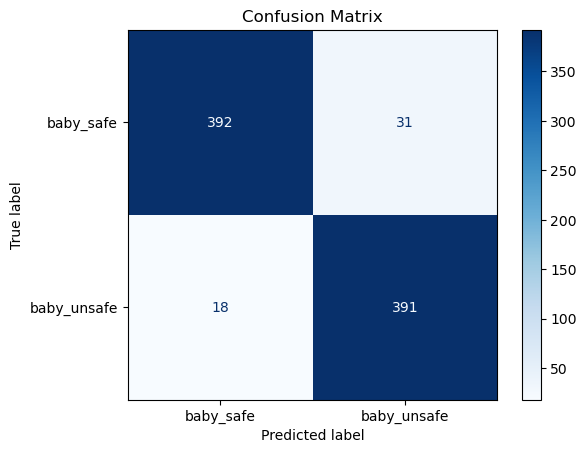

------------------------------------------------------------------------------------------
---------------------------------TOP 25 FEATURES ANALYSIS---------------------------------
------------------------------------------------------------------------------------------


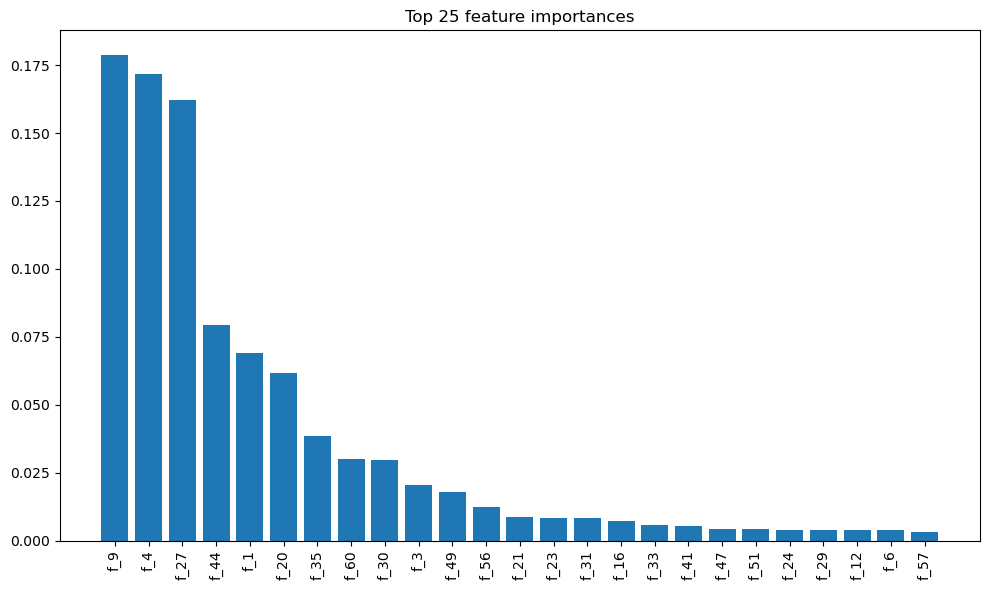

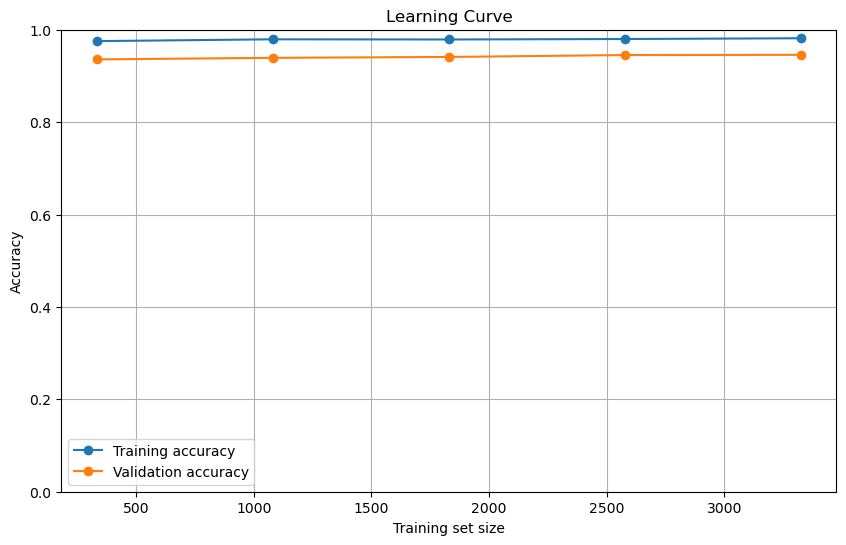


Dataset labels:----------------------------------------
{'baby_safe': 0, 'baby_unsafe': 1}

Report-------------------------------------------------
              precision    recall  f1-score   support

   baby_safe       0.95      0.94      0.95       423
 baby_unsafe       0.94      0.95      0.94       409

    accuracy                           0.94       832
   macro avg       0.94      0.94      0.94       832
weighted avg       0.94      0.94      0.94       832

Confusion matrix---------------------------------------


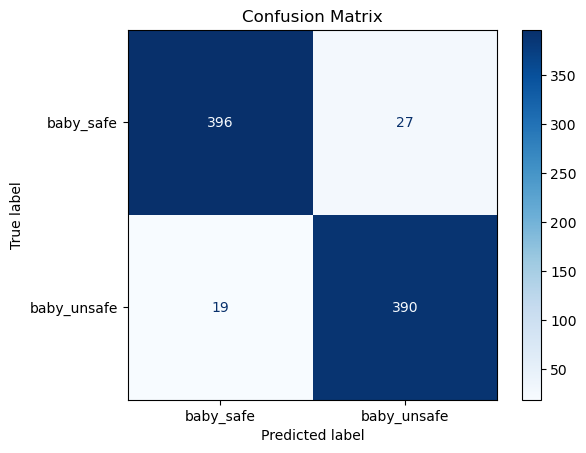

In [35]:
from scipy.stats import randint
from scipy.stats import uniform

param_dist = {
    'n_estimators': randint(100, 500), # Numero di alberi da costruire
    'learning_rate': uniform(0.01, 0.3), # Passo di apprendimento
    'max_depth': randint(3, 10), # Profondità massima di un albero
    'subsample': uniform(0.6, 0.4), # Frazione di campioni da usare per l'addestramento
    'colsample_bytree': uniform(0.6, 0.4), # Frazione di feature da usare per la costruzione di ogni albero
    'gamma': uniform(0, 0.5) # Riduzione minima della perdita richiesta per fare un'ulteriore partizione
    }
best_params_xgbc = clf.optimize_model(xgbc_1, param_dist,verbose=True)
xgbc_2 = XGBClassifier(**best_params_xgbc)
results_xgbc_2 = clf.evaluation_pipeline(xgbc_2,verbose=True,optimized=True)

In [37]:
dataset.save_embeddings(embeddings_new.iloc[:, :10])

In [32]:
xgbc_3 = XGBClassifier(**best_params_xgbc)
clf.evaluation_pipeline_with_cv(xgbc_3,verbose=True)

------------------------------------------------------------------------------------------
-----------------------------K-FOLD CROSS-VALIDATION ANALYSIS-----------------------------
------------------------------------------------------------------------------------------
Accuracy for each fold: [0.953125, 0.9555288461538461, 0.9507211538461539, 0.941034897713598, 0.9446450060168472]
Average cross-validation accuracy: 0.9490


np.float64(0.9490109807460889)

# 3) Eseguiamo Ablazione

In [38]:
emb_reduced, history = clf.iterative_ablation(
    model=xgbc_2,
    embeddings=embeddings_new,
    y=dataset.y,
    classes_bs=emb_builder.classes_bs,
    max_cycles=20,
    n_very_big_groups=10,
    very_big_group_size=10,
    n_big_groups=10,
    big_group_size=6,
    n_medium_groups=3,
    medium_group_size=10,
    n_small_groups=10,
    small_group_size=2,
    verbose=False)

In [39]:
diff1 = set(embeddings_new.columns) - set(emb_reduced.columns)  # colonne in df1 ma non in df2


print("Colonne presenti in df1 ma non in df2:", diff1)

Colonne presenti in df1 ma non in df2: {'f_8'}


------------------------------------------------------------------------------------------
--------------------------------------FIRST ANALYSIS--------------------------------------
------------------------------------------------------------------------------------------


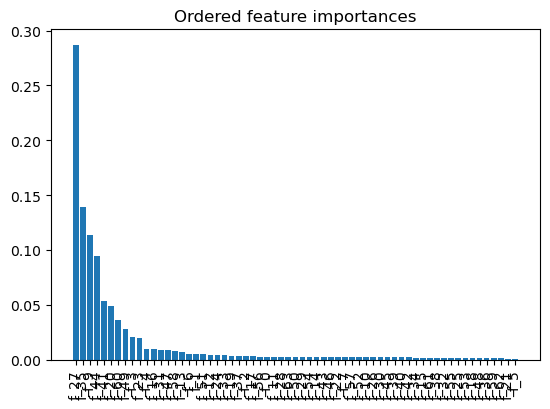

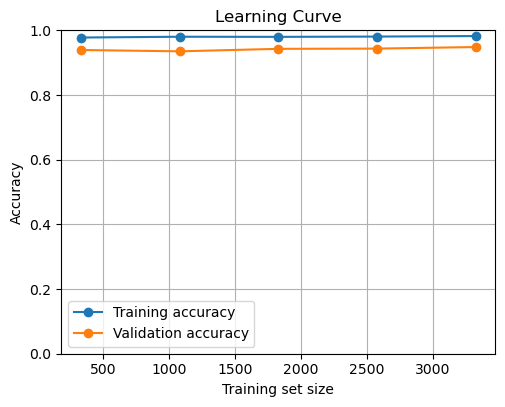


Dataset labels:----------------------------------------
{'baby_safe': 0, 'baby_unsafe': 1}

Report-------------------------------------------------
              precision    recall  f1-score   support

   baby_safe       0.96      0.95      0.95       423
 baby_unsafe       0.94      0.96      0.95       409

    accuracy                           0.95       832
   macro avg       0.95      0.95      0.95       832
weighted avg       0.95      0.95      0.95       832

Confusion matrix---------------------------------------


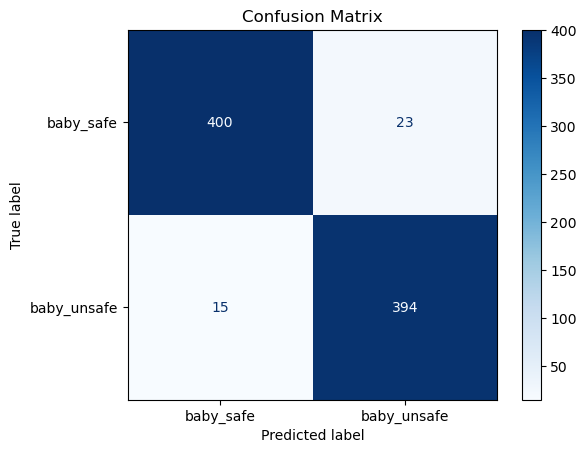

------------------------------------------------------------------------------------------
---------------------------------TOP 10 FEATURES ANALYSIS---------------------------------
------------------------------------------------------------------------------------------


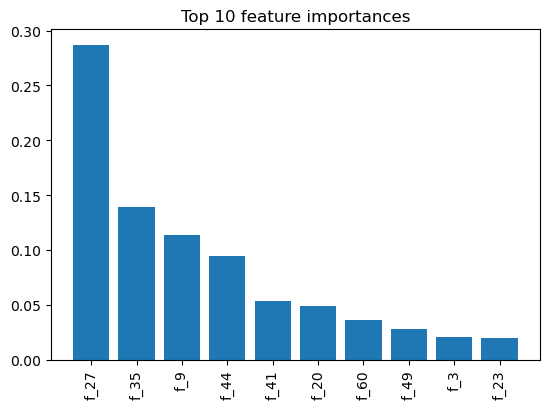

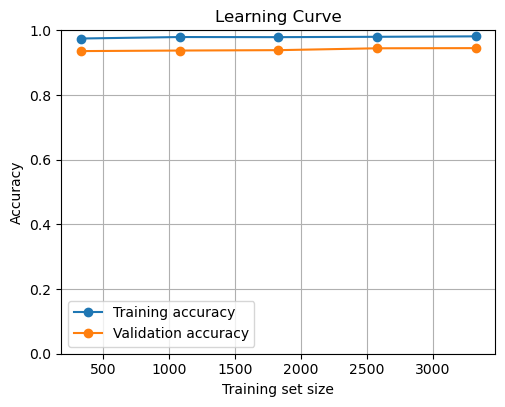


Dataset labels:----------------------------------------
{'baby_safe': 0, 'baby_unsafe': 1}

Report-------------------------------------------------
              precision    recall  f1-score   support

   baby_safe       0.96      0.93      0.95       423
 baby_unsafe       0.93      0.96      0.95       409

    accuracy                           0.95       832
   macro avg       0.95      0.95      0.95       832
weighted avg       0.95      0.95      0.95       832

Confusion matrix---------------------------------------


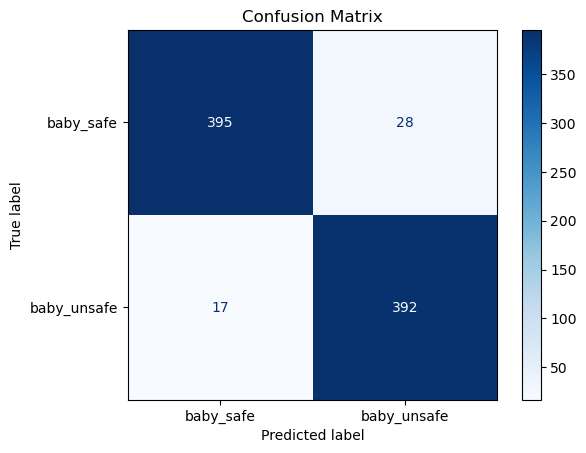

------------------------------------------------------------------------------------------
---------------------------------TOP 25 FEATURES ANALYSIS---------------------------------
------------------------------------------------------------------------------------------


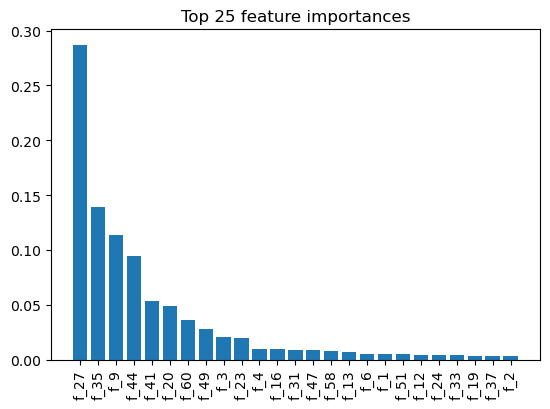

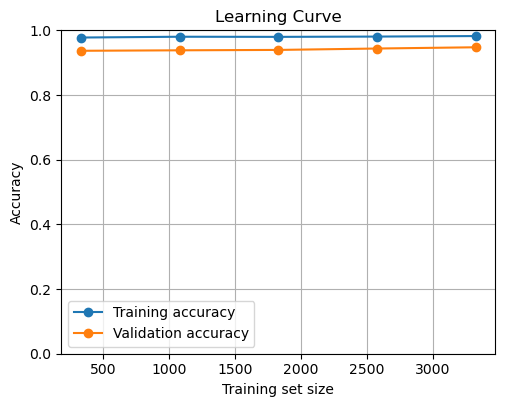


Dataset labels:----------------------------------------
{'baby_safe': 0, 'baby_unsafe': 1}

Report-------------------------------------------------
              precision    recall  f1-score   support

   baby_safe       0.95      0.94      0.95       423
 baby_unsafe       0.94      0.95      0.94       409

    accuracy                           0.94       832
   macro avg       0.94      0.94      0.94       832
weighted avg       0.94      0.94      0.94       832

Confusion matrix---------------------------------------


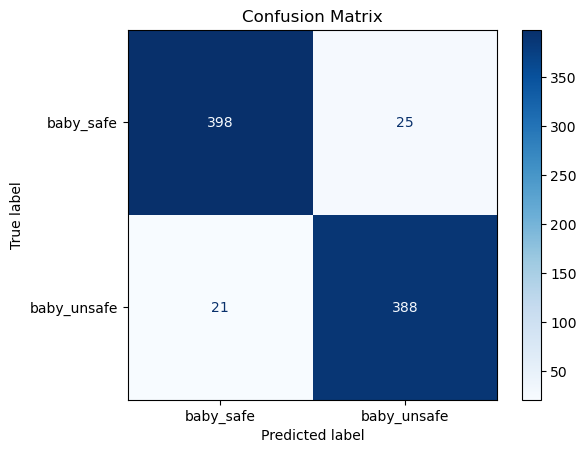

{'all_features': {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=np.float64(0.7970472375971478), device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=np.float64(0.1643758051437541), grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=np.float64(0.20002025629501774), max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=5, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=470, n_jobs=None,
                num_parallel_tree=None, ...),
  'X': array([[    -0.1247,    0.012603,     0.14913, ...,    -0.22047,    0.082049,

In [40]:
clf = Classifier(emb_reduced, dataset.y, emb_builder.classes_bs)
xgbc_4 = XGBClassifier(**best_params_xgbc)
clf.evaluation_pipeline(xgbc_4, verbose=True,optimized=True)

In [41]:
clf.evaluation_pipeline_with_cv(xgbc_4,verbose=True)

------------------------------------------------------------------------------------------
-----------------------------K-FOLD CROSS-VALIDATION ANALYSIS-----------------------------
------------------------------------------------------------------------------------------
Accuracy for each fold: [0.953125, 0.9579326923076923, 0.9495192307692307, 0.9398315282791817, 0.941034897713598]
Average cross-validation accuracy: 0.9483


np.float64(0.9482886698139404)

In [42]:
os.environ["PATH"] = "/Library/TeX/texbin:" + os.environ["PATH"]
save_as_pdf(ipynbname.path())

[NbConvertApp] Converting notebook /Users/lorenzodimaio/Download/SIDS_revelation_project/full_pipeline/MLP_classifier_parameter.ipynb to pdf
[NbConvertApp] Support files will be in /Users/lorenzodimaio/Download/SIDS_revelation_project/full_pipeline/reports/MLP_classifier_parameter(2025-09-15)_files/
[NbConvertApp] Writing 74670 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 777233 bytes to /Users/lorenzodimaio/Download/SIDS_revelation_project/full_pipeline/reports/MLP_classifier_parameter(2025-09-15).pdf
